<a href="https://colab.research.google.com/github/imabari/rakuten_tools/blob/main/saitama_ta_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アップロード

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print(
        'User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])
        )
    )

Saving 2022-05-05-23-40-47.csv to 2022-05-05-23-40-47.csv
User uploaded file "2022-05-05-23-40-47.csv" with length 52942 bytes


# 設定

In [ ]:
# 埼玉県
mid = "1VFhvD6b5JpMJb3Jr-gXM8FRm1XJjQzZe"
lid = ""

# プログラム

In [ ]:
url = f"https://www.google.com/maps/d/kml?mid={mid}" if lid == "" else f"https://www.google.com/maps/d/kml?mid={mid}&lid={lid}"
url

'https://www.google.com/maps/d/kml?mid=1VFhvD6b5JpMJb3Jr-gXM8FRm1XJjQzZe'

## 準備

In [ ]:
import pathlib
import zipfile

from lxml import etree

In [ ]:
import pandas as pd
import requests

In [ ]:
def fetch_file(url, fn):

    p = pathlib.Path(fn)

    r = requests.get(url)
    r.raise_for_status()

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [ ]:
# マイマップからデータ抽出

def get_mymap(url):

    ns = {"kml": "http://www.opengis.net/kml/2.2"}

    p = fetch_file(url, "rakuten.kmz")

    with zipfile.ZipFile(p) as existing_zip:
        existing_zip.extractall("kmz")

    tree = etree.parse("./kmz/doc.kml")

    data = []

    for i in tree.xpath("//kml:Placemark", namespaces=ns):

        d = {}

        d["場所"] = "".join(i.xpath("./kml:name/text()", namespaces=ns)).strip()
        d["geometry"] = "".join(
            i.xpath("./kml:Point/kml:coordinates/text()", namespaces=ns)
        ).strip()

        for j in i.xpath("./kml:ExtendedData/kml:Data", namespaces=ns):

            k = j.attrib["name"].strip()
            v = "".join(j.xpath("./kml:value/text()", namespaces=ns)).strip()

            d[k] = v

        data.append(d)

    df0 = pd.DataFrame(data)

    df0[["経度", "緯度", "標高"]] = df0["geometry"].str.split(",", expand=True)

    # 文字から数値に変換
    df0["経度"] = pd.to_numeric(df0["経度"])
    df0["緯度"] = pd.to_numeric(df0["緯度"])

    # 緯度・経度が欠損の場合は削除
    df0.dropna(subset=["緯度", "経度"], how="any", inplace=True)

    df0["eNBID"] = pd.to_numeric(df0["eNBID"], errors="coerce")

    df0.dropna(subset=["eNBID"], inplace=True)

    df0["eNB-LCID"] = df0["場所"].str.split(expand=True)[0]

    df1 = df0[["場所", "eNB-LCID", "緯度", "経度"]].copy()

    return df1

## TowerCollector

In [ ]:
df0 = pd.read_csv(fn, parse_dates=["measured_at"]).dropna(how="all", axis=1)
df0

,mcc,mnc,lac,cell_id,short_cell_id,rnc,psc,asu,dbm,ta,...,measured_at,net_type,neighboring,device,rsrp,rsrq,rssi,rssnr,ec_no,arfcn
0,440,11,13314,71694342,280056,6,260,17,-79,5.0,...,2022-05-05 06:57:51.906000+00:00,LTE,False,Xiaomi XIG02,-109.0,-11.0,-79.0,14.0,NaN,1500.0
1,440,11,13314,71694342,280056,6,260,15,-83,5.0,...,2022-05-05 06:58:27.885000+00:00,LTE,False,Xiaomi XIG02,-113.0,-11.0,-83.0,10.0,NaN,1500.0
2,440,11,13314,71694342,280056,6,260,18,-77,6.0,...,2022-05-05 06:59:03.863000+00:00,LTE,False,Xiaomi XIG02,-110.0,-12.0,-77.0,9.0,NaN,1500.0
3,440,11,13314,71694342,280056,6,260,16,-81,5.0,...,2022-05-05 07:01:14.854000+00:00,LTE,False,Xiaomi XIG02,-115.0,-13.0,-81.0,6.0,NaN,1500.0
4,440,11,13314,71694342,280056,6,260,18,-77,5.0,...,2022-05-05 07:01:32.863000+00:00,LTE,False,Xiaomi XIG02,-109.0,-11.0,-77.0,6.0,NaN,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,440,11,13315,71660291,279923,3,337,21,-71,5.0,...,2022-05-05 07:56:31.843000+00:00,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0
292,440,11,13315,71660291,279923,3,337,21,-71,5.0,...,2022-05-05 07:56:35.845000+00:00,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0
293,440,11,13315,71660291,279923,3,337,21,-71,5.0,...,2022-05-05 07:56:39.847000+00:00,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0
294,440,11,13315,71660291,279923,3,337,20,-73,6.0,...,2022-05-05 07:56:44.843000+00:00,LTE,False,Xiaomi XIG02,-106.0,-11.0,-73.0,6.0,NaN,1500.0


In [ ]:
# バンド指定
df1 = df0.query("mcc == 440 & mnc == 11 & net_type == 'LTE' & ta < 40").copy()

In [ ]:
# 日時変換
df1["measured_at"] = df1["measured_at"].dt.tz_convert("Asia/Tokyo").dt.tz_localize(None)

In [ ]:
# eNB-LCIDを作成
df1["id"] = df1["short_cell_id"].astype(str) + "-" + df1["rnc"].astype(str)

In [ ]:
df1["ta"] = df1["ta"].astype("Int64")

In [ ]:
df1

,mcc,mnc,lac,cell_id,short_cell_id,rnc,psc,asu,dbm,ta,...,net_type,neighboring,device,rsrp,rsrq,rssi,rssnr,ec_no,arfcn,id
0,440,11,13314,71694342,280056,6,260,17,-79,5,...,LTE,False,Xiaomi XIG02,-109.0,-11.0,-79.0,14.0,NaN,1500.0,280056-6
1,440,11,13314,71694342,280056,6,260,15,-83,5,...,LTE,False,Xiaomi XIG02,-113.0,-11.0,-83.0,10.0,NaN,1500.0,280056-6
2,440,11,13314,71694342,280056,6,260,18,-77,6,...,LTE,False,Xiaomi XIG02,-110.0,-12.0,-77.0,9.0,NaN,1500.0,280056-6
3,440,11,13314,71694342,280056,6,260,16,-81,5,...,LTE,False,Xiaomi XIG02,-115.0,-13.0,-81.0,6.0,NaN,1500.0,280056-6
4,440,11,13314,71694342,280056,6,260,18,-77,5,...,LTE,False,Xiaomi XIG02,-109.0,-11.0,-77.0,6.0,NaN,1500.0,280056-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,440,11,13315,71660291,279923,3,337,21,-71,5,...,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0,279923-3
292,440,11,13315,71660291,279923,3,337,21,-71,5,...,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0,279923-3
293,440,11,13315,71660291,279923,3,337,21,-71,5,...,LTE,False,Xiaomi XIG02,-103.0,-11.0,-71.0,6.0,NaN,1500.0,279923-3
294,440,11,13315,71660291,279923,3,337,20,-73,6,...,LTE,False,Xiaomi XIG02,-106.0,-11.0,-73.0,6.0,NaN,1500.0,279923-3


# マイマップ

In [ ]:
df2 = get_mymap(url)
df2

,場所,eNB-LCID,緯度,経度
106,359066-2 寿能町1丁目,359066-2,35.920979,139.632918
107,359069-12 高鼻町4丁目,359069-12,35.920934,139.631672
108,359069-6 寿能町1丁目,359069-6,35.920072,139.634190
151,"262149-1,2,3 高須賀","262149-1,2,3",36.069152,140.014768
153,"262197-4,5,6 手子生","262197-4,5,6",36.106862,140.028125
...,...,...,...,...
2210,359080-5 泉水3丁目,359080-5,35.808194,139.581308
2211,359080-1 本町3丁目,359080-1,35.795700,139.600289
2212,359080-2 宮戸,359080-2,35.820228,139.601753
2213,359080-3 根岸台4丁目,359080-3,35.802702,139.611726


In [ ]:
df2[["eNB", "LCID"]] = df2["eNB-LCID"].str.split("-", expand=True)
df2["LCID"] = df2["LCID"].str.split(",")

In [ ]:
df3 = df2.explode("LCID")
df3["id"] = df3["eNB"] + "-" + df3["LCID"]

df3

,場所,eNB-LCID,緯度,経度,eNB,LCID,id
106,359066-2 寿能町1丁目,359066-2,35.920979,139.632918,359066,2,359066-2
107,359069-12 高鼻町4丁目,359069-12,35.920934,139.631672,359069,12,359069-12
108,359069-6 寿能町1丁目,359069-6,35.920072,139.634190,359069,6,359069-6
151,"262149-1,2,3 高須賀","262149-1,2,3",36.069152,140.014768,262149,1,262149-1
151,"262149-1,2,3 高須賀","262149-1,2,3",36.069152,140.014768,262149,2,262149-2
...,...,...,...,...,...,...,...
2210,359080-5 泉水3丁目,359080-5,35.808194,139.581308,359080,5,359080-5
2211,359080-1 本町3丁目,359080-1,35.795700,139.600289,359080,1,359080-1
2212,359080-2 宮戸,359080-2,35.820228,139.601753,359080,2,359080-2
2213,359080-3 根岸台4丁目,359080-3,35.802702,139.611726,359080,3,359080-3


In [ ]:
df4 = pd.merge(df1, df3, on="id")
df4

,mcc,mnc,lac,cell_id,short_cell_id,rnc,psc,asu,dbm,ta,...,rssnr,ec_no,arfcn,id,場所,eNB-LCID,緯度,経度,eNB,LCID
0,440,11,11265,88168969,344410,9,145,31,-51,0,...,18.0,NaN,1500.0,344410-9,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,9
1,440,11,11265,88168969,344410,9,145,31,-51,0,...,18.0,NaN,1500.0,344410-9,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,9
2,440,11,11265,88168968,344410,8,108,31,-51,0,...,18.0,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8
3,440,11,11265,88168968,344410,8,108,31,-51,0,...,18.0,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8
4,440,11,11265,88168968,344410,8,108,31,-51,0,...,18.0,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,440,11,11265,88210950,344574,6,105,22,-69,20,...,NaN,NaN,1500.0,344574-6,"344574-5,6,7 上新井5丁目","344574-5,6,7",35.794735,139.451023,344574,6
66,440,11,11265,88147467,344326,11,72,15,-83,13,...,-2.0,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11
67,440,11,11265,88147467,344326,11,72,15,-83,13,...,-2.0,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11
68,440,11,11265,88147467,344326,11,72,20,-73,14,...,1.0,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11


# 距離計測

In [ ]:
!pip install pyproj

     |████████████████████████████████| 6.3 MB 7.7 MB/s 


In [ ]:
import pyproj

In [ ]:
grs80 = pyproj.Geod(ellps="GRS80")

In [ ]:
df4["m"] = df4.apply(lambda x: grs80.inv(x["lon"], x["lat"], x["経度"], x["緯度"])[2], axis=1)

In [ ]:
df4.dropna(subset=["ta"], inplace=True)

In [ ]:
df4

,mcc,mnc,lac,cell_id,short_cell_id,rnc,psc,asu,dbm,ta,...,ec_no,arfcn,id,場所,eNB-LCID,緯度,経度,eNB,LCID,m
0,440,11,11265,88168969,344410,9,145,31,-51,0,...,NaN,1500.0,344410-9,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,9,71.841634
1,440,11,11265,88168969,344410,9,145,31,-51,0,...,NaN,1500.0,344410-9,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,9,20.799290
2,440,11,11265,88168968,344410,8,108,31,-51,0,...,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8,20.799290
3,440,11,11265,88168968,344410,8,108,31,-51,0,...,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8,47.233426
4,440,11,11265,88168968,344410,8,108,31,-51,0,...,NaN,1500.0,344410-8,"344410-7,8,9 上山口","344410-7,8,9",35.767026,139.416257,344410,8,94.554761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,440,11,11265,88210950,344574,6,105,22,-69,20,...,NaN,1500.0,344574-6,"344574-5,6,7 上新井5丁目","344574-5,6,7",35.794735,139.451023,344574,6,3023.534673
66,440,11,11265,88147467,344326,11,72,15,-83,13,...,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11,1998.812651
67,440,11,11265,88147467,344326,11,72,15,-83,13,...,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11,2044.903669
68,440,11,11265,88147467,344326,11,72,20,-73,14,...,NaN,1500.0,344326-11,"344326-10,11,12 山口-2","344326-10,11,12",35.779651,139.441216,344326,11,2124.323428


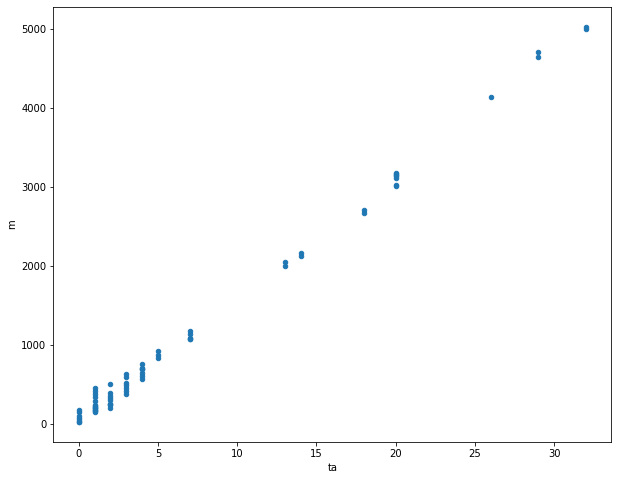

In [ ]:
df4.plot.scatter(x="ta", y="m", figsize=(10, 8))

In [ ]:
import matplotlib.pyplot as plt
from sklearn import linear_model

In [ ]:
 def reg_plot(X, Y):
 
    clf = linear_model.LinearRegression()

    clf.fit(X, Y)

    # 散布図
    plt.scatter(X, Y)

    # 回帰直線
    plt.title("antenna")
    plt.plot(X, clf.predict(X), color="red")
    plt.xlabel("TA")
    plt.ylabel("m")
    plt.grid()
    plt.show()

    print(clf.coef_[0])

    return clf.coef_[0]

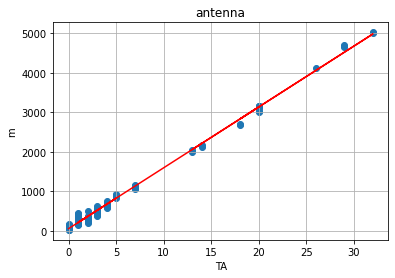

154.05611112859162


In [ ]:
n = reg_plot(df4[["ta"]].values, df4["m"].values)